<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_montly_hours   14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   Work_accident          14999 non-null  int64  
 6   left                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   Department             14999 non-null  object 
 9   salary                 14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB
None
       satisfaction_level  last_evaluation  number_project  \
count        14999.000000     14999.000000    14999.000000   
mean             0.612834         0.716102        3.803054   
std           

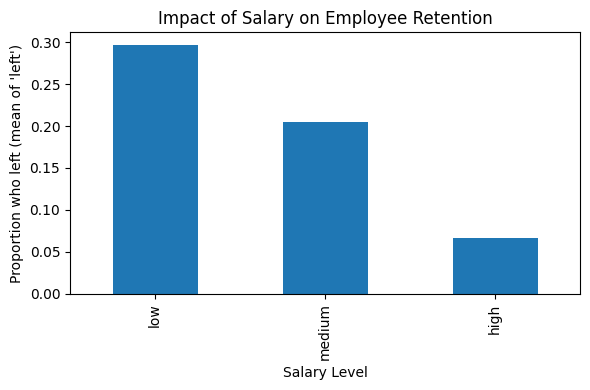

✅ Model training completed successfully!

🏁 Model Accuracy: 0.7659
🏁 ROC AUC: 0.8044

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.93      0.86      2857
           1       0.52      0.25      0.34       893

    accuracy                           0.77      3750
   macro avg       0.66      0.59      0.60      3750
weighted avg       0.73      0.77      0.73      3750



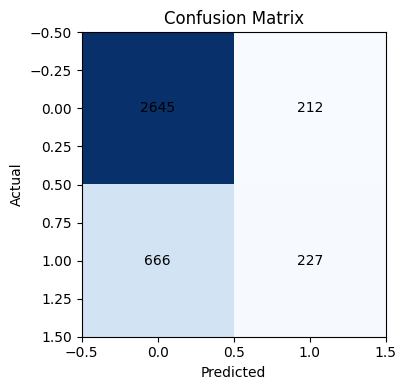

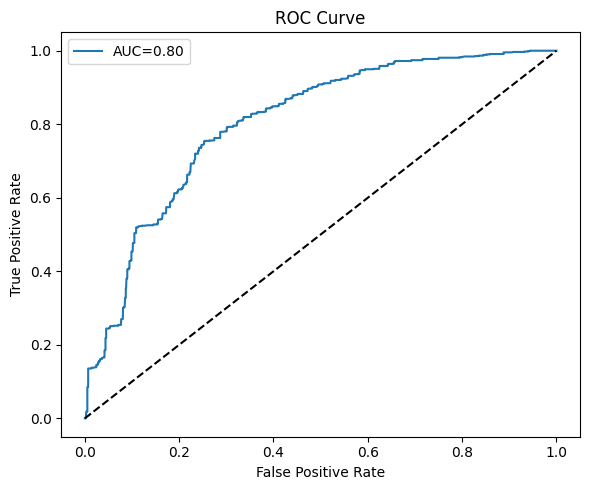


✅ Analysis complete!


In [2]:


# 1️⃣ IMPORT LIBRARIES
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pointbiserialr, chi2_contingency
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, classification_report, roc_auc_score,
    roc_curve, confusion_matrix
)
from sklearn.pipeline import Pipeline

# 2️⃣ LOAD DATA
df = pd.read_csv("C:\\Users\\shiva\\Downloads\\HR_comma_sep.csv")
df.head()


# 3️⃣ BASIC INFO
print(df.info())
print(df.describe())
print(df['left'].value_counts(normalize=True))

# 4️⃣ NUMERIC FEATURES — POINT-BISERIAL CORRELATION
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols = [c for c in numeric_cols if c != 'left']

pb_results = []
for col in numeric_cols:
    try:
        corr, p = pointbiserialr(df['left'], df[col])
    except Exception:
        corr, p = np.nan, np.nan
    pb_results.append((col, corr, p))

pb_df = pd.DataFrame(pb_results, columns=['feature', 'pointbiserial_corr', 'p_value'])
pb_df['abs_corr'] = pb_df['pointbiserial_corr'].abs()
pb_df = pb_df.sort_values(by='abs_corr', ascending=False).drop(columns=['abs_corr'])

print("\n📊 Point-biserial correlations (numeric features vs 'left'):\n")
print(pb_df.to_string(index=False))

# 5️⃣ CATEGORICAL FEATURES — CRAMÉR'S V
def cramers_v(confusion_matrix):
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    denom = min((kcorr-1), (rcorr-1))
    return np.sqrt(phi2corr / denom) if denom > 0 else 0

cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
cat_cols = [c for c in cat_cols if c != 'left']

cramer_results = []
for col in cat_cols:
    contingency = pd.crosstab(df[col], df['left'])
    v = cramers_v(contingency)
    cramer_results.append((col, v))
cramer_df = pd.DataFrame(cramer_results, columns=['feature', 'cramers_v']).sort_values(by='cramers_v', ascending=False)

print("\n📊 Cramér's V (categorical features vs 'left'):\n")
print(cramer_df.to_string(index=False))

# 6️⃣ SELECT STRONG FEATURES
num_selected = pb_df[pb_df['pointbiserial_corr'].abs() >= 0.10]['feature'].tolist()
cat_selected = cramer_df[cramer_df['cramers_v'] >= 0.08]['feature'].tolist()

print("\n✅ Selected numeric features:", num_selected)
print("✅ Selected categorical features:", cat_selected)

selected_features = num_selected + cat_selected
for extra in ['promotion_last_5years', 'Work_accident']:
    if extra in df.columns and extra not in selected_features:
        selected_features.append(extra)

print("\n🎯 Final features for model:", selected_features)


# 7️⃣ Salary vs Retention
if 'salary' in df.columns:
    salary_summary = df.groupby('salary')['left'].mean().sort_values(ascending=False)
    plt.figure(figsize=(6,4))
    salary_summary.plot(kind='bar')
    plt.title("Impact of Salary on Employee Retention")
    plt.ylabel("Proportion who left (mean of 'left')")
    plt.xlabel("Salary Level")
    plt.tight_layout()
    plt.show()

# 8️⃣ Department vs Retention
if 'department' in df.columns:
    dept_summary = df.groupby('department')['left'].mean().sort_values(ascending=False)
    plt.figure(figsize=(8,5))
    dept_summary.plot(kind='bar')
    plt.title("Impact of Department on Employee Retention")
    plt.ylabel("Proportion who left (mean of 'left')")
    plt.xlabel("Department")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


# ==========================================
# MODEL BUILDING — LOGISTIC REGRESSION
# ==========================================

# 9️⃣ Feature Matrix & Target
X = df[selected_features].copy()
y = df['left']

# 10️⃣ Identify numeric and categorical columns
num_feats = [c for c in X.columns if pd.api.types.is_numeric_dtype(X[c])]
cat_feats = [c for c in X.columns if c not in num_feats]

# ✅ Handle ordinal encoding for salary if applicable
if 'salary' in X.columns and X['salary'].dtype == object:
    mapping = {'low':0, 'medium':1, 'high':2, 'Low':0, 'Medium':1, 'High':2}
    # If salary values fit this mapping, map them to numeric
    if set(X['salary'].dropna().unique()).issubset(set(mapping.keys())):
        X['salary_mapped'] = X['salary'].map(mapping)
        if 'salary' in cat_feats:
            cat_feats.remove('salary')
        if 'salary_mapped' not in num_feats:
            num_feats.append('salary_mapped')

# ✅ Build preprocessing transformer safely
transformers = []
if len(num_feats) > 0:
    transformers.append(('num', StandardScaler(), num_feats))
if len(cat_feats) > 0:
    transformers.append(('cat', OneHotEncoder(drop='first', sparse=False), cat_feats))

preprocessor = ColumnTransformer(transformers=transformers, remainder='drop')

# ✅ Define pipeline
pipeline = Pipeline([
    ('pre', preprocessor),
    ('clf', LogisticRegression(max_iter=1000))
])

# 12️⃣ Train/Test Split & Fit
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42
)
pipeline.fit(X_train, y_train)

print("✅ Model training completed successfully!")


# 13️⃣ Predictions
y_pred = pipeline.predict(X_test)
y_proba = pipeline.predict_proba(X_test)[:,1]

# 14️⃣ Metrics
acc = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)

print(f"\n🏁 Model Accuracy: {acc:.4f}")
print(f"🏁 ROC AUC: {roc_auc:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# 15️⃣ Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
plt.imshow(cm, cmap='Blues', interpolation='nearest')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
for (i, j), val in np.ndenumerate(cm):
    plt.text(j, i, val, ha='center', va='center')
plt.tight_layout()
plt.show()

# 16️⃣ ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC={roc_auc:.2f}")
plt.plot([0,1], [0,1], 'k--')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.tight_layout()
plt.show()

print("\n✅ Analysis complete!")
